In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob


from datetime import datetime, time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


import geopandas as gpd
from shapely.geometry import Point

import xarray as xr

import supermag_api


import plotly.express as px
import plotly.graph_objs as go

from scipy.integrate import trapz

from scipy.stats import genextreme, genpareto
from pyextremes import get_return_periods




/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
# Load regions
regions_gdf = gpd.read_file("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/NERC_Reliability_Coordinators.geojson")
# Ensure the CRS is WGS84 (EPSG:4326)
if regions_gdf.crs is None or regions_gdf.crs.to_string() != "EPSG:4326":
    print('converting to EPSG: 4326')
    regions_gdf = regions_gdf.to_crs("EPSG:4326")


/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [20]:
regions_gdf

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,geometry
0,1,2775,CALIFORNIA INDEPENDENT SYSTEM OPERATOR,250 OUTCROPPING WAY,FOLSOM,CA,95630,(916) 351-4400,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,"MULTIPOLYGON (((-117.21222 32.77345, -117.2125..."
1,2,56669,"MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..",720 WEST CITY CENTER DRIVE,CARMEL,IN,46032,(317) 249-5400,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.misoenergy.org/,MISO,292.720754,149.525223,"MULTIPOLYGON (((-90.86519 29.04521, -90.86601 ..."
2,3,59504,SOUTHWEST POWER POOL,201 WORTHEN DRIVE,LITTLE ROCK,AR,72223,(501) 614-3200,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPP,124.080895,159.549276,"MULTIPOLYGON (((-90.02360 36.26603, -90.02347 ..."
3,4,14725,"PJM INTERCONNECTION, LLC",2750 MONROE BOULEVARD,AUDUBON,PA,19403,(610) 666-8980,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.pjm.com/,PJM,180.400515,60.380160,"MULTIPOLYGON (((-76.74164 34.93144, -76.74147 ..."
4,5,5723,ERCOT ISO,7620 METRO CENTER DRIVE,AUSTIN,TX,78744,(512) 225-7000,USA,"EIA 861, http://www.nerc.com/",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.ercot.com/,ERCOT,129.617465,61.005352,"MULTIPOLYGON (((-97.19964 26.00022, -97.19972 ..."
5,6,18195,"SOUTHERN COMPANY SERVICES, INC.",30 IVAN ALLEN JR. BLVD. NW,ATLANTA,GA,30308,(404) 506-5000,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.southerncompany.com/,SOCO,63.918457,31.514459,"MULTIPOLYGON (((-85.71473 30.11996, -85.71406 ..."
6,7,18642,TENNESSEE VALLEY AUTHORITY,400 W. SUMMIT HILL DR,KNOXVILLE,TN,37902,(865) 632-2101,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.tva.gov/,TVA,76.634818,34.343868,"MULTIPOLYGON (((-89.63085 33.18303, -89.54331 ..."
7,8,NA3,VACAR SOUTH,DEC-43A/550 SOUTH TRYON STREET,CHARLOTTE,NC,28202,NOT AVAILABLE,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,NOT AVAILABLE,VACS,95.622322,19.661130,"MULTIPOLYGON (((-80.88014 32.07804, -80.88029 ..."
8,9,13434,ISO NEW ENGLAND INC.,1 SULLIVAN RD,HOLYOKE,MA,01040,(413) 535-4000,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,"MULTIPOLYGON (((-73.42151 40.61798, -73.42155 ..."
9,10,13501,NEW YORK INDEPENDENT SYSTEM OPERATOR,10 KREY BOULEVARD,RENSSELAER,NY,12144,(518) 356-6000,USA,"FERC 714, EIA 860, EIA 861, TIGER/Line Shapefi...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.nyiso.com/,NYIS,49.321979,14.143104,"MULTIPOLYGON (((-74.05013 40.56642, -74.04944 ..."


In [18]:
# Read in supermag station information 
df_sm_stations = pd.read_csv('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/supermag_data/supermag-stations-information-downloadedJuly2025.csv',
                            usecols=[0,1,2,3,4,5])




In [21]:
df_sm_stations['GEOLON_alt'] = ((df_sm_stations['GEOLON'] + 180) % 360) - 180

In [22]:
df_sm_stations

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt
0,SON,66.44,25.12,139.81,19.36,Sonmiani,66.44
1,AMU,210.13,61.24,-93.38,61.32,Anchorage,-149.87
2,YKC,245.52,62.48,-56.85,69.42,Yellowknife,-114.48
3,CBB,254.97,69.12,-47.81,77.05,Cambridge Bay,-105.03
4,RES,265.11,74.69,-35.54,82.93,Resolute Bay,-94.89
...,...,...,...,...,...,...,...
593,Y17,279.36,-5.17,-7.96,7.30,Piura,-80.64
594,Y18,283.64,-6.50,-3.57,6.20,Tarapoto,-76.36
595,STT,351.27,37.55,68.41,28.53,Sao Teotonio,-8.73
596,BLO,246.58,43.93,-49.37,50.91,Bear Lake,-113.42


In [24]:
gdf_sm_stations = gpd.GeoDataFrame(
                            df_sm_stations,
                            geometry=[Point(xy) for xy in zip(df_sm_stations["GEOLON_alt"], df_sm_stations["GEOLAT"])],
                            crs="EPSG:4326"
                            )

In [26]:
gdf_sm_stations

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry
0,SON,66.44,25.12,139.81,19.36,Sonmiani,66.44,POINT (66.44000 25.12000)
1,AMU,210.13,61.24,-93.38,61.32,Anchorage,-149.87,POINT (-149.87000 61.24000)
2,YKC,245.52,62.48,-56.85,69.42,Yellowknife,-114.48,POINT (-114.48000 62.48000)
3,CBB,254.97,69.12,-47.81,77.05,Cambridge Bay,-105.03,POINT (-105.03000 69.12000)
4,RES,265.11,74.69,-35.54,82.93,Resolute Bay,-94.89,POINT (-94.89000 74.69000)
...,...,...,...,...,...,...,...,...
593,Y17,279.36,-5.17,-7.96,7.30,Piura,-80.64,POINT (-80.64000 -5.17000)
594,Y18,283.64,-6.50,-3.57,6.20,Tarapoto,-76.36,POINT (-76.36000 -6.50000)
595,STT,351.27,37.55,68.41,28.53,Sao Teotonio,-8.73,POINT (-8.73000 37.55000)
596,BLO,246.58,43.93,-49.37,50.91,Bear Lake,-113.42,POINT (-113.42000 43.93000)


In [46]:
sm_stations_locations_with_regions = gpd.sjoin(gdf_sm_stations, regions_gdf, how="left", predicate="within")
sm_stations_locations_with_regions['Region'] = sm_stations_locations_with_regions['NAME']
sm_stations_locations_with_regions_US = sm_stations_locations_with_regions.dropna(subset=['Region'], inplace=False)


In [44]:
# sm_stations_locations_with_regions


In [47]:
sm_stations_locations_with_regions_US

,IAGA,GEOLON,GEOLAT,AACGMLON,AACGMLAT,STATION-NAME,GEOLON_alt,geometry,index_right,OBJECTID,...,COUNTRY,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,WEBSITE,ABBRV,SHAPE_Length,SHAPE_Area,Region
13,BOU,254.76,40.14,-38.69,48.52,Boulder,-105.24,POINT (-105.24000 40.14000),12.0,13.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPPW,134.250252,94.978328,SOUTHWEST POWER POOL WEST
14,FRN,240.28,37.09,-54.89,42.63,Fresno,-119.72,POINT (-119.72000 37.09000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
16,NEW,242.88,48.27,-54.82,54.65,Newport,-117.12,POINT (-117.12000 48.27000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
37,FRD,282.63,38.20,-0.64,48.05,Fredericksburg,-77.37,POINT (-77.37000 38.20000),3.0,4.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.pjm.com/,PJM,180.400515,60.380160,"PJM INTERCONNECTION, LLC"
45,CDP,256.30,31.00,-35.65,39.45,Chengdu,-103.70,POINT (-103.70000 31.00000),4.0,5.0,...,USA,"EIA 861, http://www.nerc.com/",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.ercot.com/,ERCOT,129.617465,61.005352,ERCOT ISO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562,R10,288.52,42.61,7.85,51.61,Haystack,-71.48,POINT (-71.48000 42.61000),8.0,9.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,ISO NEW ENGLAND INC.
574,R11,290.44,44.29,10.61,52.97,Augusta,-69.56,POINT (-69.56000 44.29000),8.0,9.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.iso-ne.com/,ISNE,72.611648,16.621284,ISO NEW ENGLAND INC.
575,R12,242.32,47.53,-55.26,53.77,Grant,-117.68,POINT (-117.68000 47.53000),0.0,1.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,http://www.caiso.com/,RCW,223.350632,225.375431,CALIFORNIA INDEPENDENT SYSTEM OPERATOR
576,R13,256.31,40.21,-36.74,48.85,Pawnee,-103.69,POINT (-103.69000 40.21000),12.0,13.0,...,USA,"EIA 861, https://www.nerc.com/pa/rrm/TLR/Pages...",2019-12-03 00:00:00+00:00,OTHER,2022-06-03 00:00:00+00:00,https://www.spp.org/,SPPW,134.250252,94.978328,SOUTHWEST POWER POOL WEST


In [49]:
sm_stations_region = {}

grouped = sm_stations_locations_with_regions_US.groupby('Region')
for region, region_data in grouped:
    sm_stations_region[region] = [region_data['IAGA'],region_data['GEOLON_alt'],region_data['GEOLAT']]

In [56]:
sm_stations_region['MIDCONTINENT INDEPENDENT SYSTEM OPERATOR, INC..']

[345    M01
 346    M02
 347    M03
 381    C08
 383    C11
 385    C01
 386    T15
 394    T23
 395    T24
 531    T56
 553    R01
 555    R03
 559    R07
 Name: IAGA, dtype: object,
 345   -96.45
 346   -93.25
 347   -95.60
 381   -95.08
 383   -96.36
 385   -83.90
 386   -84.69
 394   -85.14
 395   -88.70
 531   -92.97
 553   -92.21
 555   -93.73
 559   -93.65
 Name: GEOLON_alt, dtype: float64,
 345    46.87
 346    45.56
 347    43.60
 381    45.87
 383    48.03
 385    42.42
 386    46.48
 394    43.66
 395    44.82
 531    45.59
 553    38.89
 555    44.90
 559    47.13
 Name: GEOLAT, dtype: float64]

In [5]:
years = np.arange(2013,2025)
print(years)

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [7]:
datetime(years[0],6,1)

datetime.datetime(2013, 6, 1, 0, 0)

In [11]:
(status,stations) = supermag_api.SuperMAGGetInventory(supermag_userid,
                                                          datetime(years[0],1,1),
                                                         86400*365)

In [2]:
supermag_userid = 'rymc1012'
flags = 'geo'


In [3]:
# (status,sm_data)=supermag_api.SuperMAGGetData(supermag_userid,
#                                      datetime(years[0],1,1),
#                                      86400*365,
#                                      flags,'FRN')

In [2]:
# Downloaded 2024 data for FRD, FRN, and R05
file_FRD = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/supermag_data/SuperMAG_60s_FRD_2024_rev-0006.1753287357.netcdf'
# ds = xr.open_dataset(file_FRD)
ds = xr.open_dataset(file_FRD, chunks={'time': 10000})

In [3]:
for var in ['time_yr', 'time_mo', 'time_dy', 'time_hr', 'time_mt', 'time_sc']:
    ds[var] = ds[var].astype(int)

In [4]:
ds = ds.drop_vars(['extent','dbe_geo','dbn_geo','dbn_geo'])

In [5]:
ds

<xarray.Dataset> Size: 46MB
Dimensions:  (block: 527040, vector: 1)
Dimensions without coordinates: block, vector
Data variables: (12/14)
    dbe_nez  (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    dbn_nez  (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    dbz_geo  (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    dbz_nez  (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    glat     (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    glon     (block, vector) float32 2MB dask.array<chunksize=(527040, 1), meta=np.ndarray>
    ...       ...
    time_dy  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
    time_hr  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
    time_mo  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
    time_mt  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
    time_sc  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
    time_yr  (block) int64 4MB dask.array<chunksize=(527040,), meta=np.ndarray>
Attributes:
    description:   \nFile contains N, E, Z from individual ground magnetomete...

In [6]:
def build_datetime_vec(y, mo, d, h, mi, s):
    y = y.astype(str)
    mo = np.char.zfill(mo.astype(str), 2)
    d = np.char.zfill(d.astype(str), 2)
    h = np.char.zfill(h.astype(str), 2)
    mi = np.char.zfill(mi.astype(str), 2)
    s = np.char.zfill(s.astype(str), 2)
    
    dt_str = np.char.add(y, '-')
    dt_str = np.char.add(dt_str, mo)
    dt_str = np.char.add(dt_str, '-')
    dt_str = np.char.add(dt_str, d)
    dt_str = np.char.add(dt_str, 'T')
    dt_str = np.char.add(dt_str, h)
    dt_str = np.char.add(dt_str, ':')
    dt_str = np.char.add(dt_str, mi)
    dt_str = np.char.add(dt_str, ':')
    dt_str = np.char.add(dt_str, s)
    
    return dt_str.astype('datetime64[ns]')


datetime_da = xr.apply_ufunc(
    build_datetime_vec,
    ds['time_yr'], ds['time_mo'], ds['time_dy'],
    ds['time_hr'], ds['time_mt'], ds['time_sc'],
    dask='allowed',
    output_dtypes=[np.dtype('datetime64[ns]')]
)


# Assign as time coordinate
ds = ds.assign_coords(time=datetime_da)


/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.char.zfill` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.char.zfill` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/Users/ryanmc/opt/anaconda3/envs/spwxr_network/lib/python3.9/site-packages/dask/array/core.py:1711: FutureWarning: The `numpy.char.zfill` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.


In [7]:
# ds = ds.assign_coords(time=pd.to_datetime(datetime_da.values))

In [7]:
ds['time'] = pd.to_datetime(ds['time'].values)



In [8]:
H = np.sqrt(ds['dbe_nez']**2 + ds['dbn_nez']**2)
ds['H'] = H

ds['H'] = ds['H'].rename({'block': 'time'})
H_1d = ds['H'].squeeze('vector')  # dims: ('time',)


In [9]:
dH = ds['H'].diff('time')
dt = ds['time'].diff('time') / np.timedelta64(1, 's')
dt = dt.astype('float64')  # ensure float for safe division


dH_dt = dH / dt
dH_dt = dH_dt.pad(time=(1, 0), constant_values=np.nan)  # align dimensions
ds['dH_dt'] = dH_dt


In [10]:
ds['dH_dt'].shape

(527040, 1)

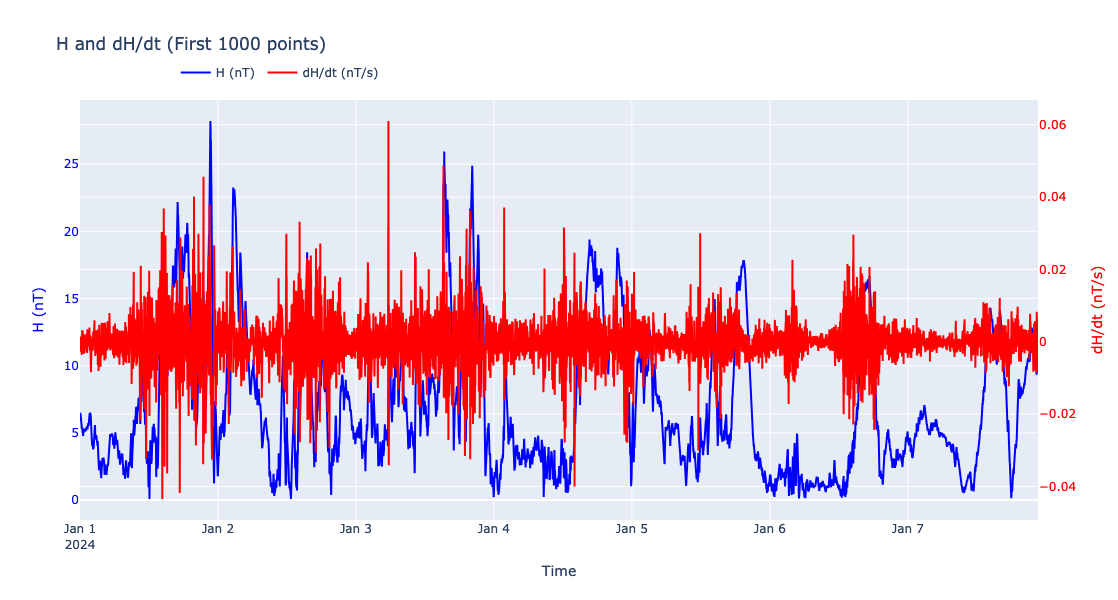

In [14]:
import plotly.graph_objects as go

# Subset dataframe (already done)
df_subset = ds[['H', 'dH_dt']].isel(time=slice(0, 10000)).to_dataframe().reset_index()

fig = go.Figure()

# Add H trace (left y-axis)
fig.add_trace(go.Scatter(
    x=df_subset['time'],
    y=df_subset['H'],
    name='H (nT)',
    line=dict(color='blue'),
    yaxis='y1'
))

# Add dH/dt trace (right y-axis)
fig.add_trace(go.Scatter(
    x=df_subset['time'],
    y=df_subset['dH_dt'],
    name='dH/dt (nT/s)',
    line=dict(color='red'),
    yaxis='y2'
))

# Create axis objects
fig.update_layout(
    title='H and dH/dt (First 1000 points)',
    xaxis=dict(title='Time'),
    yaxis=dict(
        title='H (nT)',
        titlefont=dict(color='blue'),
        tickfont=dict(color='blue'),
        side='left'
    ),
    yaxis2=dict(
        title='dH/dt (nT/s)',
        titlefont=dict(color='red'),
        tickfont=dict(color='red'),
        overlaying='y',
        side='right'
    ),
    height=600,
    legend=dict(x=0.1, y=1.1, orientation='h')
)

fig.show()


In [15]:
block_max_H = H_da.resample(time='D').max()
block_max_dHdt = dHdt_da.resample(time='D').max()

NameError: name 'H_da' is not defined

In [26]:
H_da = xr.DataArray(ds['H'].data, dims=['time'], coords={'time': ds.coords['time']})
dHdt_da = xr.DataArray(ds['dH_dt'].data, dims=['time'], coords={'time': ds.coords['time']})

block_max_H = H_da.resample(time='D').max()
block_max_dHdt = dHdt_da.resample(time='D').max()

ValueError: different number of dimensions on data and dims: 2 vs 1

In [16]:
#EVA 


# # Resample to monthly block maxima
# block_max_H = ds['H'].resample(time='M').max()
# block_max_dHdt = ds['dH_dt'].resample(time='M').max()

# Resample to daily block maxima
block_max_H = ds['H'].resample(time='D').max()
block_max_dHdt = ds['dH_dt'].resample(time='D').max()


# Drop NaNs
block_H = block_max_H.values
block_H = block_H[np.isfinite(block_H)]

# Fit GEV
shape_H, loc_H, scale_H = genextreme.fit(block_H)


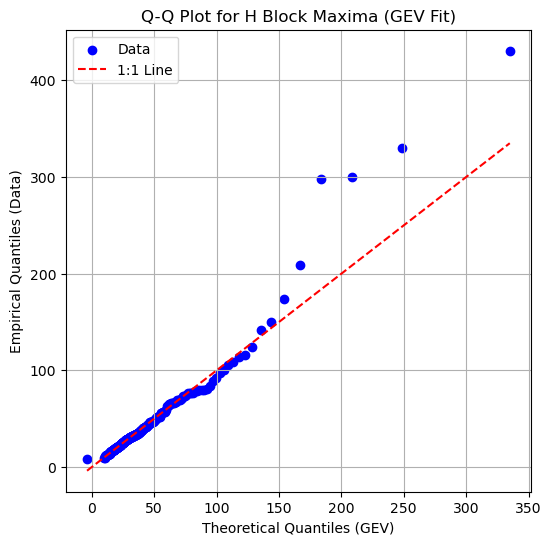

In [17]:

# Compute theoretical quantiles
percs = np.linspace(0, 100, len(block_H))
q_empirical = np.percentile(block_H, percs)
q_theoretical = genextreme.ppf(percs / 100, shape_H, loc=loc_H, scale=scale_H)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(q_theoretical, q_empirical, c='blue', label='Data')
plt.plot(q_theoretical, q_theoretical, 'r--', label='1:1 Line')
plt.xlabel('Theoretical Quantiles (GEV)')
plt.ylabel('Empirical Quantiles (Data)')
plt.title('Q-Q Plot for H Block Maxima (GEV Fit)')
plt.legend()
plt.grid(True)
plt.show()


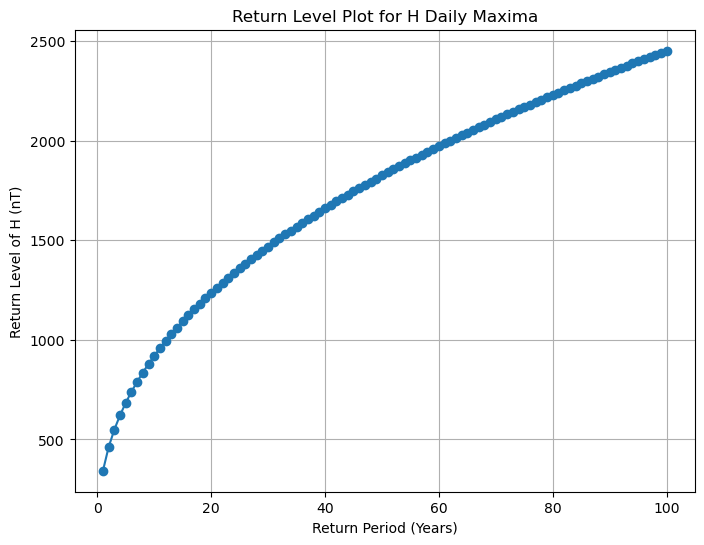

In [18]:
# Return Level Plot
return_periods = np.linspace(1, 100, 100)
p = 1 - 1 / (return_periods * 365.25)
return_levels = genextreme.ppf(p, shape_H, loc=loc_H, scale=scale_H)

plt.figure(figsize=(8, 6))
plt.plot(return_periods, return_levels, marker='o')
plt.xlabel('Return Period (Years)')
plt.ylabel('Return Level of H (nT)')
plt.title('Return Level Plot for H Daily Maxima')
plt.grid(True)
plt.show()


In [ ]:
# Plot
fig = px.line(df, x='time', y=['dbe_geo', 'dbn_geo'], title='dB/dt GEO for FRD')
fig.show()

In [8]:
print(ds)
print(ds.nbytes / 1e9, "GB")

<xarray.Dataset> Size: 31MB
Dimensions:  (block: 527040, vector: 1)
Dimensions without coordinates: block, vector
Data variables: (12/14)
    dbe_nez  (block, vector) float32 2MB ...
    dbn_nez  (block, vector) float32 2MB ...
    dbz_geo  (block, vector) float32 2MB ...
    dbz_nez  (block, vector) float32 2MB ...
    glat     (block, vector) float32 2MB ...
    glon     (block, vector) float32 2MB ...
    ...       ...
    time_dy  (block) int16 1MB 1 1 1 1 1 1 1 1 1 ... 31 31 31 31 31 31 31 31 31
    time_hr  (block) int16 1MB 0 0 0 0 0 0 0 0 0 ... 23 23 23 23 23 23 23 23 23
    time_mo  (block) int16 1MB 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12
    time_mt  (block) int16 1MB 0 1 2 3 4 5 6 7 8 ... 51 52 53 54 55 56 57 58 59
    time_sc  (block) float64 4MB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time_yr  (block) int16 1MB 2024 2024 2024 2024 2024 ... 2024 2024 2024 2024
Attributes:
    description:   \nFile contains N, E, Z from individual ground magnetomete...
